# Virtually No Tag Triplet Loss Neural Network Documentation

## Introduction

This document serves as the development location and documentation for the triplet loss neural network used for Virtually No Tag.

## General Idea

Alright, so previously use of a simple autoencoder was explored as a means of tie-breaking license plates. It appears to be somehwat effective for differentiating designs, but less effective at differentiating the specific plate. This may be because:

* Autoencoder has nothing in the loss term about minimizing or maximizing any euclidean distance (does not try to separate the classes)
* Autoencoder will attempt to encode useless information such as shadows, lighting differences, dirtiness, blurriness, etc, which have nothing to do with whether two images of plates are of the same plate.

With triplet loss, instead of using the input as the desired output, we use whether or not the two plates are the same as the "desired output", and for the loss we have it as a function of the distance between the encoded versions of the plates. If the plates are the same, then the distance should be minimized. If the pates are different, then the distance should at least exceed some margin or otherwise be maximized. This way, the network will care only about whether plates images are of the same plate or not, and hopefully then ignore useless information like shadows, lighting, skew, dirtiness, blurriness, etc. 

## Implementation

We will use Keras to implement the network. The network must consist of two primary parts: the encoder and the loss function. The encoder will be used 3 times in a training step for an anchor image, a positive match, and a negative mismatch. The loss will be such that it is maximized if either the anchor image and positive match's encoded forms have high euclidean distance, OR if the anchor image and negative mismatch have low euclidean distance.

In [1]:
# Imports

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Input
from keras.layers import Concatenate
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras import optimizers


from keras.models import Model

from keras.utils import to_categorical

from keras import backend as K

from os import listdir
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


We want to create our training triplets. For this, we need to of course be loading all images from disk, but also we need to carefully construct our triplets so they each consist of an anchor, positive match, and negative match. We have 8 photos of each car. Thus, we can make nCr(8, 2) anchor pairs per car. We have plenty of negatives to pick from, since nCr(8, 2) is only 28, and we have way more than 28 other images of other plates. We'll simply pick these at random.

Thus, realistically, our number of triplets possible to create is nCr(8, 2) * number_of_cars. For the set of 206 cars, this means 5768 training triplets can be constructed.

In [2]:
def getRandomNegativeIndex(loadedImages, carIndex):
    numLoadedImages = len(loadedImages)
    negativeFakeIndex = random.randint(0, numLoadedImages-1-8)
    firstExcludedImageIndex = 8*carIndex
    if negativeFakeIndex < firstExcludedImageIndex:
        return negativeFakeIndex
    else:
        return negativeFakeIndex+8
    

# Requires that the images are named such that in lexicographical order, they are in groups
# of 8, where each group is 8 images of the same plate.
#
# Returns a 5D array of the shape (n, t, h, w, c) where n is number of training triplets,
# t is 3 (for anchor, positive, negative), and (h, w, c) is just a 3-channel image.
def loadAllTheData(path):
    print("Loading all JPEG images from disk...")
    imageList = sorted(listdir(path))
    loadedImages = []
    for imageName in imageList:
        if (not (imageName.endswith(".jpg") or imageName.endswith(".jpeg"))):
            continue
        image = cv2.imread(path + imageName)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('float32') / 255.0
        loadedImages.append(np.asarray(image))
    print("Finished " + str(len(loadedImages)) + " loading!")
    numTriplets = 28 * (len(loadedImages)/8)
    print("Forming " + str(numTriplets) + " triplets")
    tripletsList = [[]]
    for carIndex in range(0, len(loadedImages)//8):
        startIndex = carIndex*8
        for i in range(0, 8-1):
            anchorIndex = startIndex+i
            for j in range(i+1, 8):
                positiveIndex = startIndex+j
                negativeIndex = getRandomNegativeIndex(loadedImages, carIndex)
                
                print("Forming triplet with anchor " + str(anchorIndex) + ", positive " + str(positiveIndex) + ", and negative " + str(negativeIndex))
                
                combined = [[]]
                combined[0].append(loadedImages[anchorIndex])
                combined[0].append(loadedImages[positiveIndex])
                combined[0].append(loadedImages[negativeIndex])
                triplet = np.concatenate(combined, axis=0)
                tripletsList[0].append(triplet)
                
    return np.concatenate(tripletsList, axis=0)        
    print("Done!")
    
allTripletData = loadAllTheData("./plate_data/plates/")
print("allTripletData has shape " + str(allTripletData.shape))

Loading all JPEG images from disk...
Finished 432 loading!
Forming 1512.0 triplets
Forming triplet with anchor 0, positive 1, and negative 97
Forming triplet with anchor 0, positive 2, and negative 302
Forming triplet with anchor 0, positive 3, and negative 274
Forming triplet with anchor 0, positive 4, and negative 245
Forming triplet with anchor 0, positive 5, and negative 36
Forming triplet with anchor 0, positive 6, and negative 361
Forming triplet with anchor 0, positive 7, and negative 182
Forming triplet with anchor 1, positive 2, and negative 190
Forming triplet with anchor 1, positive 3, and negative 117
Forming triplet with anchor 1, positive 4, and negative 171
Forming triplet with anchor 1, positive 5, and negative 119
Forming triplet with anchor 1, positive 6, and negative 392
Forming triplet with anchor 1, positive 7, and negative 69
Forming triplet with anchor 2, positive 3, and negative 292
Forming triplet with anchor 2, positive 4, and negative 75
Forming triplet with 

Forming triplet with anchor 115, positive 117, and negative 29
Forming triplet with anchor 115, positive 118, and negative 356
Forming triplet with anchor 115, positive 119, and negative 313
Forming triplet with anchor 116, positive 117, and negative 316
Forming triplet with anchor 116, positive 118, and negative 182
Forming triplet with anchor 116, positive 119, and negative 232
Forming triplet with anchor 117, positive 118, and negative 382
Forming triplet with anchor 117, positive 119, and negative 94
Forming triplet with anchor 118, positive 119, and negative 211
Forming triplet with anchor 120, positive 121, and negative 80
Forming triplet with anchor 120, positive 122, and negative 344
Forming triplet with anchor 120, positive 123, and negative 341
Forming triplet with anchor 120, positive 124, and negative 133
Forming triplet with anchor 120, positive 125, and negative 325
Forming triplet with anchor 120, positive 126, and negative 421
Forming triplet with anchor 120, positive 1

Forming triplet with anchor 220, positive 223, and negative 90
Forming triplet with anchor 221, positive 222, and negative 294
Forming triplet with anchor 221, positive 223, and negative 137
Forming triplet with anchor 222, positive 223, and negative 112
Forming triplet with anchor 224, positive 225, and negative 316
Forming triplet with anchor 224, positive 226, and negative 268
Forming triplet with anchor 224, positive 227, and negative 127
Forming triplet with anchor 224, positive 228, and negative 369
Forming triplet with anchor 224, positive 229, and negative 58
Forming triplet with anchor 224, positive 230, and negative 42
Forming triplet with anchor 224, positive 231, and negative 403
Forming triplet with anchor 225, positive 226, and negative 205
Forming triplet with anchor 225, positive 227, and negative 383
Forming triplet with anchor 225, positive 228, and negative 144
Forming triplet with anchor 225, positive 229, and negative 266
Forming triplet with anchor 225, positive 2

Forming triplet with anchor 330, positive 334, and negative 227
Forming triplet with anchor 330, positive 335, and negative 406
Forming triplet with anchor 331, positive 332, and negative 28
Forming triplet with anchor 331, positive 333, and negative 391
Forming triplet with anchor 331, positive 334, and negative 397
Forming triplet with anchor 331, positive 335, and negative 122
Forming triplet with anchor 332, positive 333, and negative 72
Forming triplet with anchor 332, positive 334, and negative 363
Forming triplet with anchor 332, positive 335, and negative 144
Forming triplet with anchor 333, positive 334, and negative 179
Forming triplet with anchor 333, positive 335, and negative 114
Forming triplet with anchor 334, positive 335, and negative 77
Forming triplet with anchor 336, positive 337, and negative 267
Forming triplet with anchor 336, positive 338, and negative 276
Forming triplet with anchor 336, positive 339, and negative 323
Forming triplet with anchor 336, positive 3

allTripletData has shape (1512, 3, 96, 192, 3)


Let's have a look at the first 84 triplets generated...

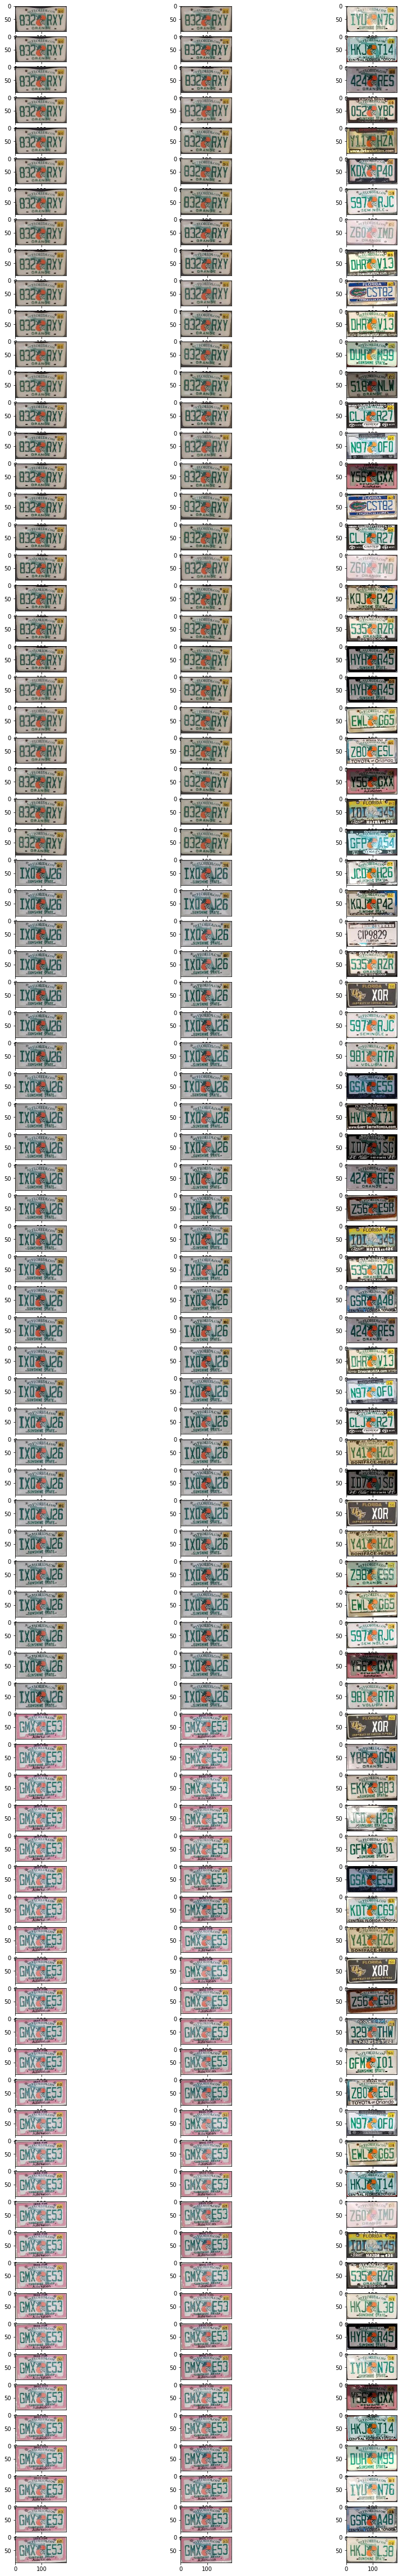

In [3]:
nrows = 84
ncols = 3
fig = plt.figure(figsize=(15, nrows))
for r in range(0, nrows):
    fig.add_subplot(nrows, ncols, r*ncols+1)
    plt.imshow(allTripletData[r][0])
    fig.add_subplot(nrows, ncols, r*ncols+2)
    plt.imshow(allTripletData[r][1])
    fig.add_subplot(nrows, ncols, r*ncols+3)
    plt.imshow(allTripletData[r][2])
plt.show()

Now that we have our triplets created, we can get to constructing our network

In [4]:
desired_vector_size = 128
batch_size = 27

input_anchor = Input(shape=(96, 192, 3))
input_positive = Input(shape=(96, 192, 3))
input_negative = Input(shape=(96, 192, 3))

In [5]:
single_input = Input(shape=(96, 192, 3))
conv_1 = Conv2D(32, (11,11), activation='relu', padding='same')(single_input)
max_pool_1 = MaxPooling2D((2,2))(conv_1)
conv_2 = Conv2D(32, (5,5), activation='relu', padding='same')(max_pool_1)
max_pool_2 = MaxPooling2D((2,2))(conv_2)
conv_3 = Conv2D(16, (3,3), activation='relu', padding='same')(max_pool_2)
max_pool_3 = MaxPooling2D((2,2))(conv_3)
conv_4 = Conv2D(16, (3,3), activation='relu', padding='same')(max_pool_3)
max_pool_4 = MaxPooling2D((2,2))(conv_4)
encoded = Dense(desired_vector_size, activation='relu')(Flatten()(max_pool_4))

encoder_model = Model(single_input, encoded)
print(encoder_model.summary())

encoded_anchor = encoder_model(input_anchor)
encoded_positive = encoder_model(input_positive)
encoded_negative = encoder_model(input_negative)

concat_all = Concatenate(axis=1)([encoded_anchor, encoded_positive, encoded_negative])

tripletLossModel = Model([input_anchor, input_positive, input_negative], concat_all)
print(tripletLossModel.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 96, 192, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 192, 32)       11648     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 96, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 48, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 24, 16)        0         
__________

In [6]:
def customLossFunction(_, yPred):
    margin = K.constant(5.0)
    
    distance_anchor_positive = K.max(K.sqrt(K.sum(K.square(yPred[:,0:desired_vector_size]-yPred[:,desired_vector_size:2*desired_vector_size]), axis=1)))
    distance_anchor_negative = K.min(K.sqrt(K.sum(K.square(yPred[:,0:desired_vector_size]-yPred[:,2*desired_vector_size:3*desired_vector_size]), axis=1)))
    
    #return (distance_anchor_positive+margin) / distance_anchor_negative
    return distance_anchor_positive+K.max([margin-distance_anchor_negative, K.constant(0)])

In [7]:
tripletLossModel.compile(optimizer=optimizers.Adam(decay=0.000000001), loss=customLossFunction)

In [8]:
encoder_model.load_weights("version_minmax_15_94.h5")

In [ ]:
# create dummy y data
y_data = np.zeros(shape=(len(allTripletData), desired_vector_size*3))

version = 2
while True:
    tripletLossModel.fit(x=[allTripletData[:,0], allTripletData[:,1], allTripletData[:,2]], y=y_data, epochs=10, batch_size=batch_size)
    jpegs = loadAllJPEGImages("./plate_data/plates/")
    accuracy = getAccuracy(jpegs, encoder_model.predict(jpegs))
    print("Accuracy is " + str(accuracy))
    encoder_model.save("version_minmax_" + str(version) + "_" + str(int(accuracy*100.0)) + ".h5")
    version += 1
    

In [9]:
def loadAllJPEGImages(path):
    print("Loading all JPEG images from disk...")
    imageList = sorted(listdir(path))
    loadedImages = [[]]
    for imageName in imageList:
        if (not (imageName.endswith(".jpg") or imageName.endswith(".jpeg"))):
            continue
        image = cv2.imread(path + imageName)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('float32') / 255.0
        loadedImages[0].append(np.asarray(image))
    print("Finished " + str(len(loadedImages[0])) + " loading!")
    output = np.concatenate(loadedImages, axis=0)
    return output


In [10]:
results = encoder_model.predict(loadAllJPEGImages("./plate_data/plates_test/"))
print(results.shape)

Loading all JPEG images from disk...
Finished 136 loading!
(136, 128)


In [11]:
def ed(v1, v2):
    return np.sqrt(np.sum(np.square(v1-v2)))

Loading all JPEG images from disk...
Finished 136 loading!


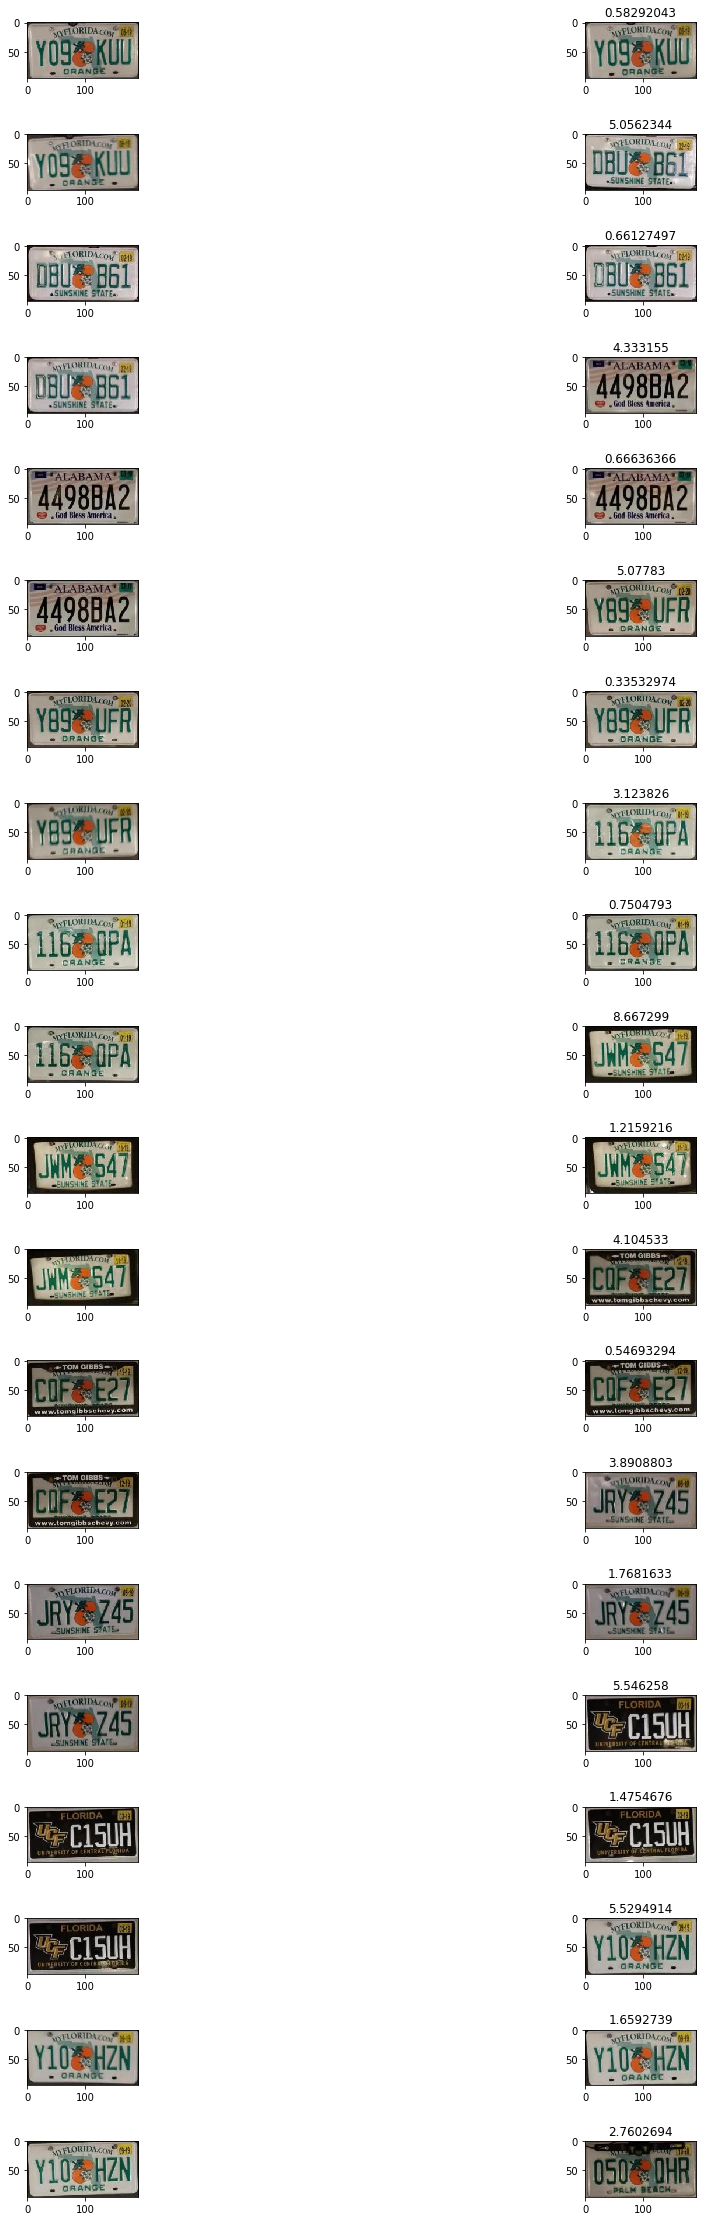

In [12]:
allJPEGImages = loadAllJPEGImages("./plate_data/plates_test/")

nrows = 20
ncols = 2
fig = plt.figure(figsize=(15, nrows*2))
for r in range(0, nrows):
    firstIndex = 3+r*4
    secondIndex = 3+r*4+1
    fig.add_subplot(nrows, ncols, r*ncols+1)
    plt.imshow(allJPEGImages[firstIndex])
    f2 = fig.add_subplot(nrows, ncols, r*ncols+2)
    f2.title.set_text(ed(results[firstIndex], results[secondIndex]))
    plt.imshow(allJPEGImages[secondIndex])
    

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)
plt.show()

In [13]:
def displayRange(first, lastExclusive, imageList):
    nrows = lastExclusive-first
    ncols = 1
    fig = plt.figure(figsize=(15, nrows*2))
    for r in range(0, nrows):
        fig.add_subplot(nrows, ncols, r+1)
        plt.imshow(imageList[first+r])
    plt.show()

In [14]:
# Save the model
# encoder_model.save("epoch_756_triplets.h5")

### Accuracy Measurement

To measure accuracy, we'll simply run through all possible pairs of data and see if the criteria gets met. That is, if they are the same plate, is encoded distance less than 5?

In [15]:
def isSameLicensePlate(index1, index2):
    # Two license plates are the same if they are within the same group of 8.
    # First find the beginning of the group of 8 that the smaller plate is in
    smaller = min(index1, index2)
    larger = max(index1, index2)
    beginningIndex = 0
    while (smaller >= beginningIndex+8):
        beginningIndex += 8
    
    # Alright, now we simply determine if larger is also in that group!
    return (larger >= beginningIndex and larger < beginningIndex+8)

def getAccuracy(allJPEGImages, results):
    correct = 0
    incorrect = 0
    for i in range(0, allJPEGImages.shape[0]-1):
        for j in range(i+1, allJPEGImages.shape[0]):
            dist = ed(results[i], results[j])
            isCorrect = isSameLicensePlate(i, j) == (dist <= 2.5)
            if isCorrect:
                correct += 1
            else:
                incorrect += 1
                print("Incorrect for pair " + str(i) + ", " + str(j) + " with status " +  str(isSameLicensePlate(i, j)) + ", " + str(dist))
                
    print("Total of " + str(correct+incorrect) + " pairs")
    return (correct)/(correct+incorrect)

encoder_model.load_weights("version_minmax_13_97.h5")
results = encoder_model.predict(loadAllJPEGImages("./plate_data/plates_test/"))
print(results.shape)
print("Total accuracy of " + str(getAccuracy(allJPEGImages, results)))

Loading all JPEG images from disk...
Finished 136 loading!
(136, 128)
Incorrect for pair 1, 29 with status False, 2.3024762
Incorrect for pair 1, 31 with status False, 2.04094
Incorrect for pair 3, 31 with status False, 2.1905358
Incorrect for pair 4, 29 with status False, 2.321119
Incorrect for pair 4, 30 with status False, 2.3830767
Incorrect for pair 4, 31 with status False, 1.8562089
Incorrect for pair 8, 96 with status False, 2.203331
Incorrect for pair 8, 97 with status False, 2.3933477
Incorrect for pair 9, 96 with status False, 2.269371
Incorrect for pair 10, 96 with status False, 2.0247593
Incorrect for pair 10, 97 with status False, 2.1904013
Incorrect for pair 10, 102 with status False, 2.4526896
Incorrect for pair 10, 103 with status False, 2.4275496
Incorrect for pair 11, 96 with status False, 2.1143103
Incorrect for pair 11, 97 with status False, 2.284519
Incorrect for pair 12, 96 with status False, 1.9762081
Incorrect for pair 12, 97 with status False, 2.124971
Incorrect

In [16]:
# How about another accuracy measurement
def getAverageFailures(results):
    failuresAvg = 0
    for i in range(results.shape[0]):
        failures = 8
        print(str(i) + " matched ", end="")
        for j in range(results.shape[0]):
            if ed(results[i], results[j]) <= 2.5:
                if isSameLicensePlate(i, j):
                    # Correct match
                    print("" + str(j) + " ", end="")
                    failures -= 1
                else:
                    # Incorrect match
                    print("[" + str(j) + "] ", end="")
                    failures += 1
        print("; total of " + str(failures) + " failures.")
        failuresAvg += failures
    return failuresAvg / results.shape[0]

encoder_model.load_weights("version_minmax_13_97.h5")
results = encoder_model.predict(loadAllJPEGImages("./plate_data/plates_test/"))
print(getAverageFailures(results))

Loading all JPEG images from disk...
Finished 136 loading!
0 matched 0 1 2 3 4 5 6 7 ; total of 0 failures.
1 matched 0 1 2 3 4 5 6 7 [29] [31] ; total of 2 failures.
2 matched 0 1 2 3 4 5 6 7 ; total of 0 failures.
3 matched 0 1 2 3 4 5 6 7 [31] ; total of 1 failures.
4 matched 0 1 2 3 4 5 6 7 [29] [30] [31] ; total of 3 failures.
5 matched 0 1 2 3 4 5 6 7 ; total of 0 failures.
6 matched 0 1 2 3 4 5 6 7 ; total of 0 failures.
7 matched 0 1 2 3 4 5 6 7 ; total of 0 failures.
8 matched 8 9 10 11 12 13 14 15 [96] [97] ; total of 2 failures.
9 matched 8 9 10 11 12 13 14 15 [96] ; total of 1 failures.
10 matched 8 9 10 11 12 13 14 15 [96] [97] [102] [103] ; total of 4 failures.
11 matched 8 9 10 11 12 13 14 15 [96] [97] ; total of 2 failures.
12 matched 8 9 10 11 12 13 14 15 [96] [97] ; total of 2 failures.
13 matched 8 9 10 11 12 13 14 15 [59] ; total of 1 failures.
14 matched 8 9 10 11 12 13 14 15 [96] ; total of 1 failures.
15 matched 8 9 10 11 12 13 14 15 [59] [96] [97] ; total of 3 f

Loading all JPEG images from disk...
Finished 136 loading!


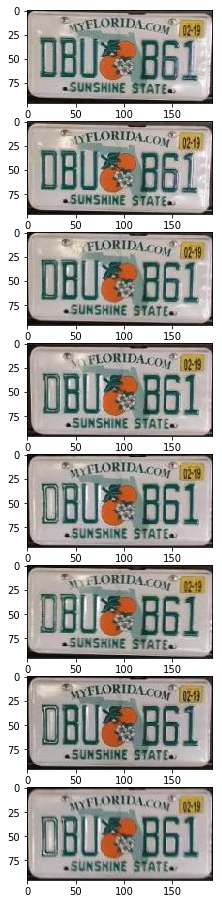

Loading all JPEG images from disk...
Finished 136 loading!


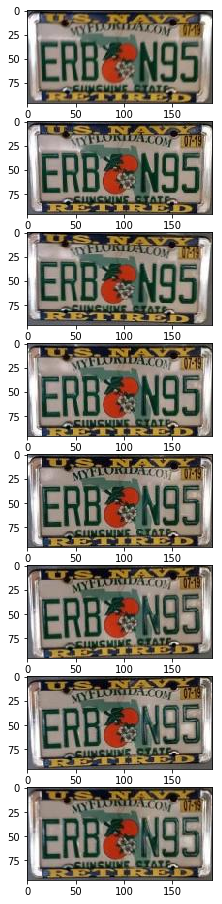

In [17]:
displayRange(8, 8+8, loadAllJPEGImages("./plate_data/plates_test/"))
displayRange(96, 96+8, loadAllJPEGImages("./plate_data/plates_test/"))